In [1]:
% matplotlib inline

from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np


from keras.regularizers import L1L2


/Users/natacha/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Predict Friday's oil price

- In this notebook we will try to add more features, in particular a lagged data of 10

In [2]:
file='/Users/natacha/Downloads/OPEC-ORB_quanl.csv'
#del(data_file)

/Users/natacha/anaconda/lib/python3.5/site-packages/pandas/core/series.py:3724: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


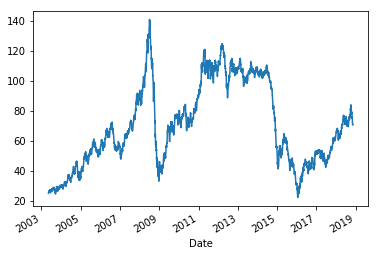

In [3]:
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv(file, header=0)[::-1][91:]
series.plot()
pyplot.show()

In [4]:
series.head()

Date
2003-05-12    25.32
2003-05-13    25.41
2003-05-14    26.13
2003-05-15    26.21
2003-05-16    26.24
Name: Value, dtype: float64

In [5]:
series.tail()

Date
2018-11-02    71.36
2018-11-05    71.45
2018-11-06    70.88
2018-11-07    70.63
2018-11-08    70.68
Name: Value, dtype: float64

In [5]:
len(series)

4002

In [6]:
n_t=800

In [7]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df
 

In [209]:
features=20
supervised = timeseries_to_supervised(series.values, features)
supervised_values = supervised.values[features:,:]

In [210]:
train, test = supervised_values[0:-n_t, :], supervised_values[-n_t:, :]



In [175]:
series.tail()

Date
2018-11-02    71.36
2018-11-05    71.45
2018-11-06    70.88
2018-11-07    70.63
2018-11-08    70.68
Name: Value, dtype: float64

In [211]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 

In [212]:
scaler, train_scaled, test_scaled = scale(train, test)

In [214]:
train_scaled[0]


array([-0.95720818, -0.96635321, -0.96721594, -0.96083168, -0.96065913,
       -0.96738849, -0.97498059, -0.97118454, -0.97135709, -0.96462773,
       -0.96497282, -0.97049435, -0.96859632, -0.9779139 , -0.97049435,
       -0.97549823, -0.97601587, -0.97739626, -0.98981969, -0.99137262,
       -0.95323958])

Train on 3182 samples, validate on 800 samples
Epoch 1/10
 - 2s - loss: 0.7590 - val_loss: 0.3990
Epoch 2/10
 - 1s - loss: 0.2396 - val_loss: 0.1476
Epoch 3/10
 - 1s - loss: 0.1012 - val_loss: 0.0861
Epoch 4/10
 - 1s - loss: 0.0673 - val_loss: 0.0633
Epoch 5/10
 - 1s - loss: 0.0542 - val_loss: 0.0554
Epoch 6/10
 - 1s - loss: 0.0485 - val_loss: 0.0495
Epoch 7/10
 - 1s - loss: 0.0440 - val_loss: 0.0449
Epoch 8/10
 - 1s - loss: 0.0403 - val_loss: 0.0412
Epoch 9/10
 - 1s - loss: 0.0374 - val_loss: 0.0383
Epoch 10/10
 - 1s - loss: 0.0349 - val_loss: 0.0359


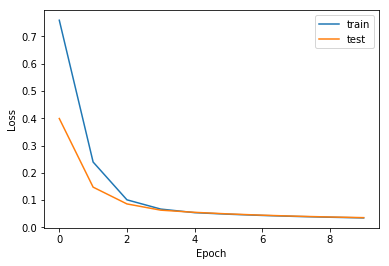

In [215]:
X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
test_X,test_y=test_scaled[:, 0:-1], test_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])
test_X=test_X.reshape(test_X.shape[0], 1, test_X.shape[1])


model = Sequential()
model.add(LSTM(5, input_shape=(X.shape[1], X.shape[2]),
              bias_regularizer= L1L2(l1=0.01, l2=0.01) ,
                   kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model
history = model.fit(X, y,
                    epochs=10,
                    batch_size=10, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)
# Plotting the training progression
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel("Epoch")
pyplot.ylabel("Loss")
pyplot.show()

In [184]:
X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
test_X,test_y=test_scaled[:, 0:-1], test_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])
test_X=test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [216]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((test_X[:, 0:], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat) 
inv_yhat = inv_yhat[:, features]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 0:], test_y), axis=1) 
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, features]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat)) 

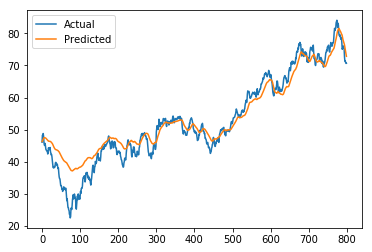

In [217]:
pyplot.plot(inv_y, label = 'Actual')
pyplot.plot(inv_yhat, label = 'Predicted')
pyplot.legend()
pyplot.show()

- Cool Discovery: More features act as a bias in our model. It is smoothing out the predictions! =)

In [221]:

test_X,test_y=test_scaled[:, 0:-1], test_scaled[:, -1]

test_X=test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [218]:
def prediction_array(a):
    aa=model.predict(np.array([a]))
    
    #eliminates first element
    #a[:,1:]
    #appends a number at the end and protects the format
    b=np.array([np.append(a[:,1:],aa)])
    
    return b

In [219]:
def rec_pre(a,n):
    if n==0:
        return prediction_array(a)
    else:
        return rec_pre(prediction_array(a),n-1)
 

- To make predictions we need to move foward our model to the future 6 days.
- We already know this won't be a good prediction since our model only knows the day before

In [222]:
x_p=rec_pre(test_X[-1],5)
y_p=rec_pre(test_X[-1],6)

In [224]:
#need to append the last step with the prediction in order to invert scaler
pre=np.array([np.append(x_p[:,0],y_p)])
inv_pre=scaler.inverse_transform(pre)

In [225]:
print("The Friday's price of oil is USA {}".format(inv_pre[:,-1][0]))

The Friday's price of oil is USA 75.70351707875727
